In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib

In [3]:
# %matplotlib widget
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from calendar import month_name, month_abbr
import dateparser

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr
from cartopy import crs as ccrs

### plotting 
from matplotlib import pyplot as plt

In [4]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

In [5]:
sys.path.append('../../') 

In [6]:
from ICU_Water_Watch import geo, C3S, domains, plot

### get the individual EEZs

In [7]:
dpath_shapes = HOME.joinpath('operational/ICU/development/hotspots/data/shapefiles')

In [8]:
EEZs, merged_EEZs = geo.get_EEZs(dpath_shapes)

<AxesSubplot:>

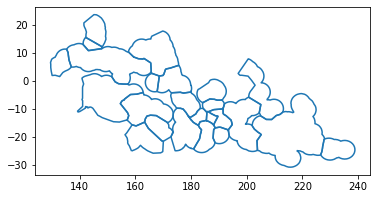

In [9]:
EEZs.boundary.plot()

<AxesSubplot:>

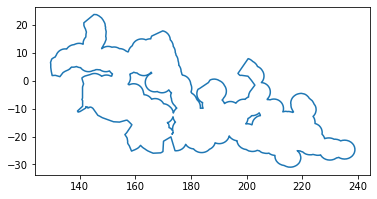

In [10]:
merged_EEZs.boundary.plot()

### year and month (nominal initial month of the forecasts)

In [11]:
date = 'The 30th of September 2021'

In [12]:
parsed_date = dateparser.parse(date)

In [13]:
parsed_date

datetime.datetime(2021, 9, 30, 0, 0)

In [14]:
year = parsed_date.year

In [15]:
month = parsed_date.month

### number of days for the GPM-IMERG accumulation statistics (inc. percentile of score)

In [16]:
ndays = 90 

### list the files GPM-IMERG first 

In [17]:
def sort_key(f): 
    from datetime import datetime
    return datetime.strptime(f.name.split('_')[-1].split('.')[0], '%Y-%m-%d') 

In [18]:
dpath_GPM = HOME.joinpath('operational/ICU/development/hotspots/outputs/GPM_IMERG')

In [19]:
lfiles = list(dpath_GPM.glob(f"GPM_IMERG_accum_{ndays}ndays_to_*.nc"))

In [20]:
lfiles.sort(key=sort_key)

In [21]:
lfiles[-4]

PosixPath('/home/nicolasf/operational/ICU/development/hotspots/outputs/GPM_IMERG/GPM_IMERG_accum_90ndays_to_2021-09-30.nc')

### we assume we want the last day of the month preceding the nominal forecast start 

In [22]:
if datetime(year, month, 1) - timedelta(days=1) in [sort_key(f) for f in lfiles]: 
    
    ifile = [sort_key(f) for f in lfiles].index(datetime(year, month, 1) - timedelta(days=1)) 
    
    dset_gpm = xr.open_dataset(lfiles[ifile])

else: 
    
    print(f"GPM file for date {datetime(year, month, 1) - timedelta(days=1):%Y-%m-%d} not in {str(dpath_GPM)}")

GPM file for date 2021-08-31 not in /home/nicolasf/operational/ICU/development/hotspots/outputs/GPM_IMERG


In [23]:
lfiles[-4]

PosixPath('/home/nicolasf/operational/ICU/development/hotspots/outputs/GPM_IMERG/GPM_IMERG_accum_90ndays_to_2021-09-30.nc')

In [24]:
dset_gpm = xr.open_dataset(lfiles[-4])

In [25]:
dset_gpm

<xarray.Dataset>
Dimensions:           (time: 1, lat: 220, lon: 439)
Coordinates:
  * time              (time) datetime64[ns] 2021-09-30
  * lat               (lat) float64 -30.88 -30.62 -30.38 ... 23.38 23.62 23.88
  * lon               (lon) float64 129.4 129.6 129.9 ... 238.4 238.6 238.9
Data variables:
    precipitationCal  (time, lat, lon) float64 ...
    pctscore          (time, lat, lon) float64 ...
    anoms             (time, lat, lon) float64 ...
    EEZ               (lat, lon) float64 ...
Attributes:
    BeginDate:       2021-07-03
    BeginTime:       00:00:00.000Z
    EndDate:         2021-07-03
    EndTime:         23:59:59.999Z
    FileHeader:      StartGranuleDateTime=2021-07-03T00:00:00.000Z;\nStopGran...
    InputPointer:    3B-HHR-L.MS.MRG.3IMERG.20210703-S000000-E002959.0000.V06...
    title:           GPM IMERG Late Precipitation L3 1 day 0.1 degree x 0.1 d...
    DOI:             10.5067/GPM/IMERGDL/DAY/06
    ProductionTime:  2021-07-04T13:43:09.676Z
    ndays:           90
    last_day:        2021-09-30

### quick plot of the percentiles of score for the past 90 days 

In [26]:
dset_gpm.lon.min()

<xarray.DataArray 'lon' ()>
array(129.375)

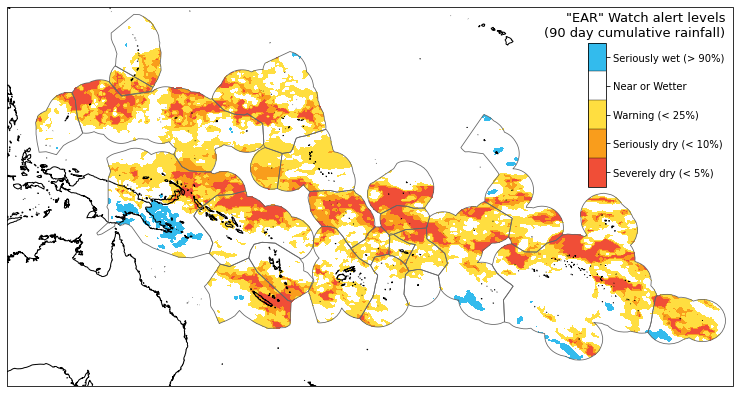

In [27]:
plot.map_EAR_Watch_Pacific(dset_gpm, close=False, mask='EEZ', geoms=EEZs)

### read the probabilistic forecasts from the GCMs now 

In [28]:
period = 'monthly'

In [29]:
if period == 'seasonal': 
    offset = 3
elif period == 'monthly': 
    offset = 1

In [30]:
quantile = 'percentile'

In [31]:
varname = 'precip'

In [32]:
dpath = CWD.parents[1].joinpath("outputs/C3S")

### list the files 

In [33]:
lfiles = list(dpath.glob(f"{period}_{quantile}s_probabilities_from_{year}-{str(month).zfill(2)}_*.netcdf"))

In [34]:
[f.name for f in lfiles]

['monthly_percentiles_probabilities_from_2021-09_ECCC.netcdf',
 'monthly_percentiles_probabilities_from_2021-09_DWD.netcdf',
 'monthly_percentiles_probabilities_from_2021-09_METEO_FRANCE.netcdf',
 'monthly_percentiles_probabilities_from_2021-09_CMCC.netcdf',
 'monthly_percentiles_probabilities_from_2021-09_UKMO.netcdf',
 'monthly_percentiles_probabilities_from_2021-09_NCEP.netcdf',
 'monthly_percentiles_probabilities_from_2021-09_ECMWF.netcdf',
 'monthly_percentiles_probabilities_from_2021-09_JMA.netcdf']

In [35]:
probs = xr.open_mfdataset(lfiles, concat_dim='GCM', engine='netcdf4') 

In [36]:
probs

,Array,Chunk
Bytes,62.81 MiB,7.85 MiB
Shape,"(8, 21, 1, 5, 81, 121)","(1, 21, 1, 5, 81, 121)"
Count,24 Tasks,8 Chunks
Type,float64,numpy.ndarray


### calculates the average across the GCM dimension 

In [37]:
probs_mean = probs.mean('GCM')

### because of all the numerical approximations, it can happen that the sum (over the `GCM` dimension) ends up slightly over 100 (the errors accumulate over all the dimensions)

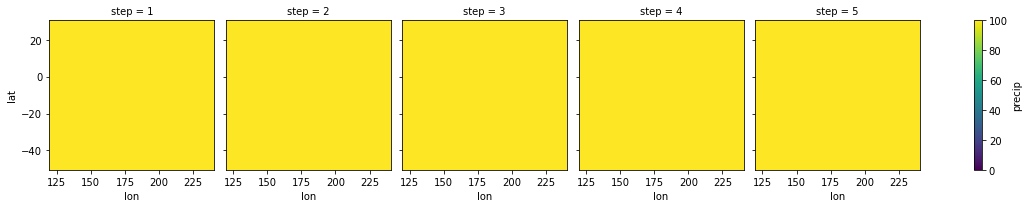

In [38]:
_ = probs_mean.sum(quantile).squeeze()[varname].plot(col='step', vmin=0)

### so we rescale, just in case, if there were not values over 100, it does not change anything 

In [39]:
probs_mean = (probs_mean / probs_mean.sum(quantile)) * 100

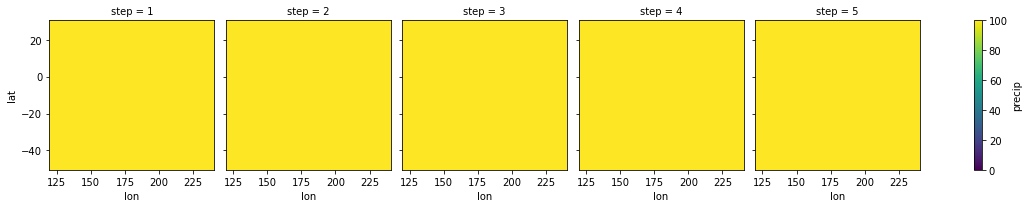

In [40]:
_ = probs_mean.sum(quantile).squeeze()['precip'].plot(col='step', vmin=0)

In [41]:
probs_mean.attrs = probs.attrs

In [42]:
probs_mean

<xarray.Dataset>
Dimensions:     (time: 1, lon: 121, lat: 81, step: 5, percentile: 21)
Coordinates:
  * time        (time) datetime64[ns] 2021-09-01
  * lon         (lon) float32 120.0 121.0 122.0 123.0 ... 238.0 239.0 240.0
  * lat         (lat) float32 -50.0 -49.0 -48.0 -47.0 ... 27.0 28.0 29.0 30.0
  * step        (step) int64 1 2 3 4 5
    month       int64 9
  * percentile  (percentile) int64 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21
Data variables:
    precip      (percentile, time, step, lat, lon) float64 dask.array<chunksize=(21, 1, 5, 81, 121), meta=np.ndarray>
Attributes:
    pct_values:  [0.02 0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55...

### subsets and interpolates on the GPM grid 

In [43]:
probs_mean = probs_mean.sel(lon=slice(dset_gpm['lon'].min(), dset_gpm['lon'].max()), lat=slice(dset_gpm['lat'].min(), dset_gpm['lat'].max()))

In [44]:
probs_mean = probs_mean.interp_like(dset_gpm[['lon','lat']], method='linear')

### probability for being below a given percentile

#### choose the percentile here 

In [45]:
print(" | ".join(map(str, probs_mean.attrs['pct_values'].tolist()))) 

0.02 | 0.05 | 0.1 | 0.15 | 0.2 | 0.25 | 0.3 | 0.35 | 0.4 | 0.45 | 0.5 | 0.55 | 0.6 | 0.65 | 0.7 | 0.75 | 0.8 | 0.85 | 0.9 | 0.95


In [46]:
pmax = 25

In [47]:
percentile_bins = probs_mean.attrs['pct_values']

max_cat = np.digitize(pmax / 100, percentile_bins)

In [48]:
max_cat

6

In [49]:
pmin = 25

In [50]:
min_cat = np.digitize(pmin / 100, percentile_bins)

In [51]:
min_cat

6

### probability of being below the given `pmax` percentile (25th percentile)

In [52]:
prob_below = probs_mean.sel(percentile=slice(None, max_cat)).sum(dim='percentile')

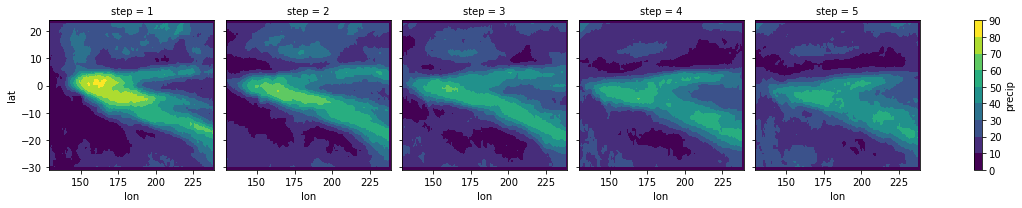

In [53]:
_ = prob_below['precip'].plot(levels=10, col='step')

### minimum probability for rainfall being below `pmax` or above `pmin`

In [54]:
min_prob = 50

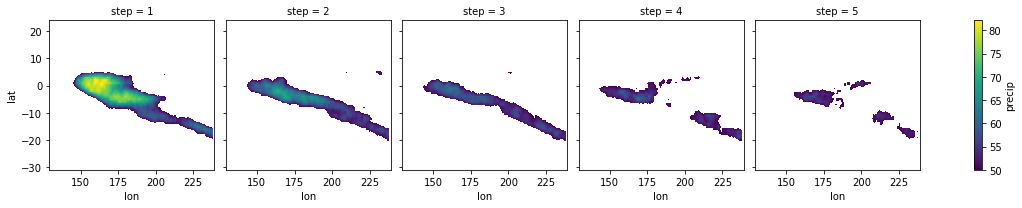

In [55]:
_ = prob_below.where(prob_below >= min_prob)['precip'].squeeze().plot(col='step', vmin=min_prob)

### probability for being above the given {pmin} percentile (25th percentile) 

In [56]:
prob_above = probs_mean.sel(percentile=slice(min_cat, None)).sum(dim='percentile')

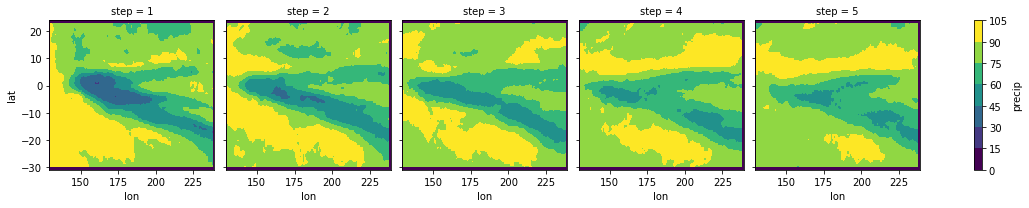

In [57]:
_ = prob_above['precip'].plot(levels=10, col='step')

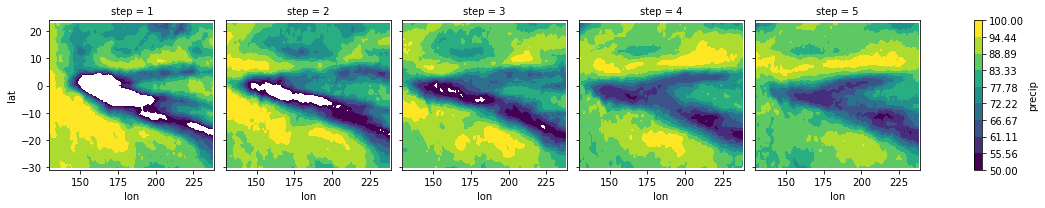

In [58]:
_ = prob_above.where(prob_above >= min_prob)['precip'].squeeze().plot.contourf(levels=10, col='step', vmin=min_prob)

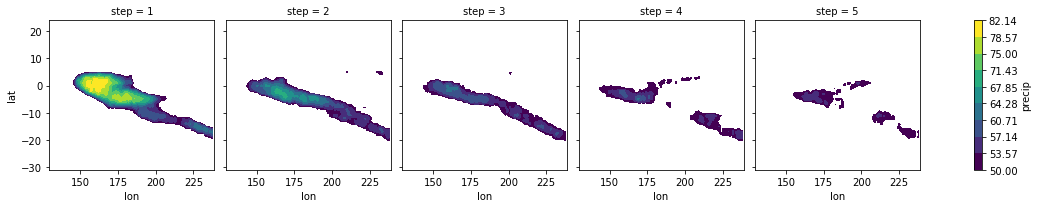

In [59]:
_ = prob_below.where(prob_below >= min_prob)['precip'].squeeze().plot.contourf(levels=10, col='step', vmin=min_prob)

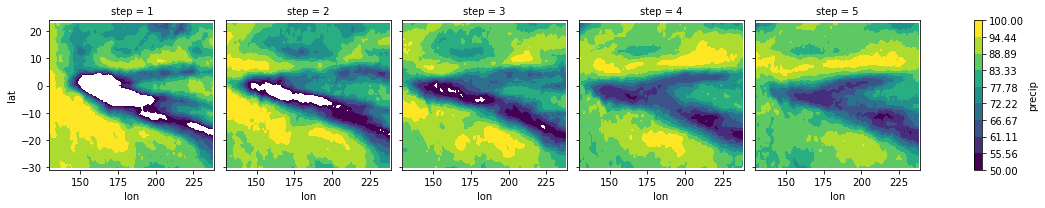

In [60]:
_ = prob_above.where(prob_above >= min_prob)['precip'].squeeze().plot.contourf(levels=10, col='step', vmin=min_prob)

### Now rename, and consolidate the forecast probabilities for being below `pmax` (renamed 'B'), above `pmin` (renamed 'A'), and the percentiles of score for GPM (renamed 'GPM') 

In [61]:
prob_below = prob_below.rename({'precip':'B'})

In [62]:
prob_above = prob_above.rename({'precip':'A'})

In [63]:
gpm = dset_gpm[['pctscore','EEZ']].rename({'pctscore':'GPM'}).squeeze().drop('time')

In [64]:
consolidated_dset = xr.merge([prob_below, prob_above, gpm]) 

In [65]:
consolidated_dset

<xarray.Dataset>
Dimensions:  (time: 1, step: 5, lat: 220, lon: 439)
Coordinates:
  * time     (time) datetime64[ns] 2021-09-01
  * step     (step) int64 1 2 3 4 5
    month    int64 9
  * lat      (lat) float64 -30.88 -30.62 -30.38 -30.12 ... 23.38 23.62 23.88
  * lon      (lon) float64 129.4 129.6 129.9 130.1 ... 238.1 238.4 238.6 238.9
Data variables:
    B        (time, step, lat, lon) float64 dask.array<chunksize=(1, 5, 220, 439), meta=np.ndarray>
    A        (time, step, lat, lon) float64 dask.array<chunksize=(1, 5, 220, 439), meta=np.ndarray>
    GPM      (lat, lon) float64 30.0 31.0 18.0 18.0 19.0 ... 46.0 52.0 67.0 81.0
    EEZ      (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan

### HOTSPOT ANALYSIS

quick plot of the probability of being below the 25th percentile

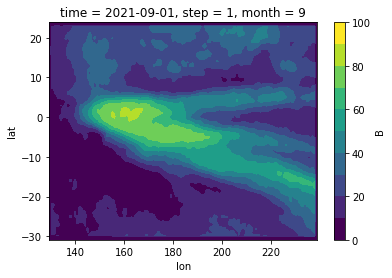

In [66]:
consolidated_dset['B'].squeeze().sel(step=offset).plot.contourf(levels=np.arange(0,110,10))

quick plot of the probability of being above the 25th percentile

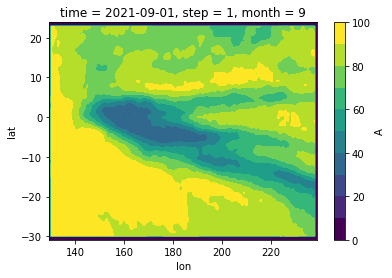

In [67]:
consolidated_dset['A'].squeeze().sel(step=offset).plot.contourf(levels=np.arange(0,110,10))

### FIRST CATEGORY: areas moving to water stress conditions  

#### 1st condition: the past 90 days accumulation  (variable `GPM`) needs to be **between** the 25th AND 40th percentile 

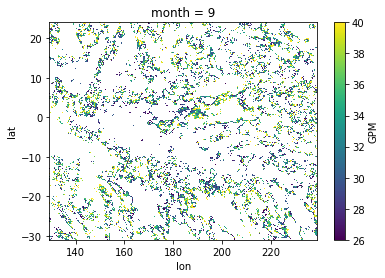

In [68]:
consolidated_dset[['GPM']].where(consolidated_dset['GPM'] <= 40).where(consolidated_dset['GPM'] > 25)['GPM'].plot()

In [69]:
hotspot_1 = consolidated_dset[['B']].where(consolidated_dset['GPM'] <= 40).where(consolidated_dset['GPM'] > 25).squeeze()

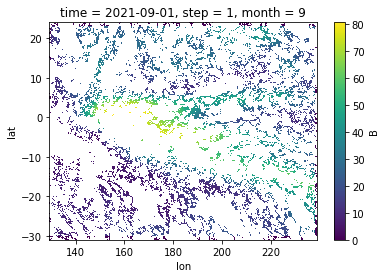

In [70]:
hotspot_1.sel(step=offset)['B'].plot()

#### 2nd condition, next month (forecast, 'B' for below `pmax`) has at least a `min_prob` probability for rainfall being below the 25th percentile 

In [71]:
hotspot_1 = hotspot_1.where(hotspot_1.sel(step=offset) >= min_prob)

#### the result gets assigned category 1

In [72]:
hotspot_1 = hotspot_1.where(np.isnan(hotspot_1), other=1)

### then we rename 

In [73]:
hotspot_1 = hotspot_1.rename({'B':'hotspot'})

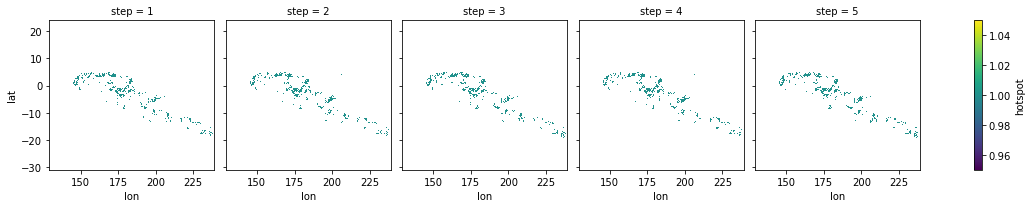

In [74]:
hotspot_1['hotspot'].plot(col='step')

### SECOND CATEGORY: current water stress conditions, persisting or getting worse 

#### 1st condition, the past 90 days accumulation (variable `GPM`) needs to be below or equal to the 25th percentile 

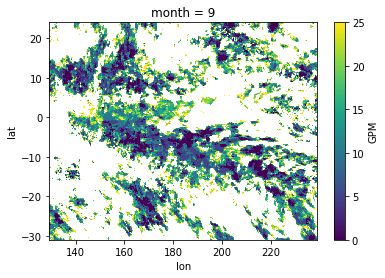

In [75]:
consolidated_dset[['GPM']].where(consolidated_dset['GPM'] <= 25)['GPM'].plot()

In [76]:
hotspot_2 = consolidated_dset[['B']].where(consolidated_dset['GPM'] <= 25).squeeze()

#### 2nd condition, next month (forecast, 'B' for below `pmax`) has at least a `min_prob` probability for rainfall being below the 25th percentile 

In [77]:
hotspot_2 = hotspot_2.where(hotspot_2.sel(step=offset) >=  min_prob)

#### the result gets assigned category 2

In [78]:
hotspot_2 = hotspot_2.where(np.isnan(hotspot_2), other=2)

### rename 

In [79]:
hotspot_2 = hotspot_2.rename({'B':'hotspot'})

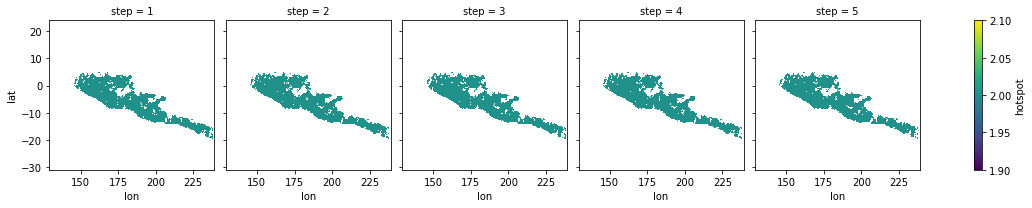

In [80]:
hotspot_2['hotspot'].plot(col='step')

### THIRD CATEGORY: current water stress conditions potentially easing 

#### 1st condition: the past 90 days accumulation needs to be below or equal to the 25th percentile 

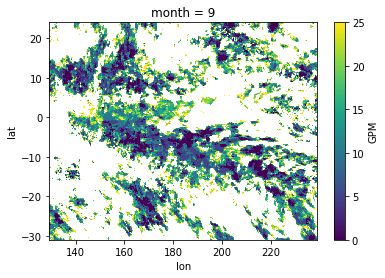

In [81]:
consolidated_dset[['GPM']].where(consolidated_dset['GPM'] <= 25)['GPM'].plot()

In [82]:
hotspot_3 = consolidated_dset[['A']].where(consolidated_dset['GPM'] <= 25).squeeze()

#### 2nd condition: next month probability for rainfall being above {pmin} ('A') is above {min_prob}

In [83]:
hotspot_3 = hotspot_3.where(hotspot_3.sel(step=offset) >= min_prob) 

#### the result gets assigned category 2

In [84]:
hotspot_3 = hotspot_3.where(np.isnan(hotspot_3), other=3)

### rename 

In [85]:
hotspot_3 = hotspot_3.rename({'A':'hotspot'})

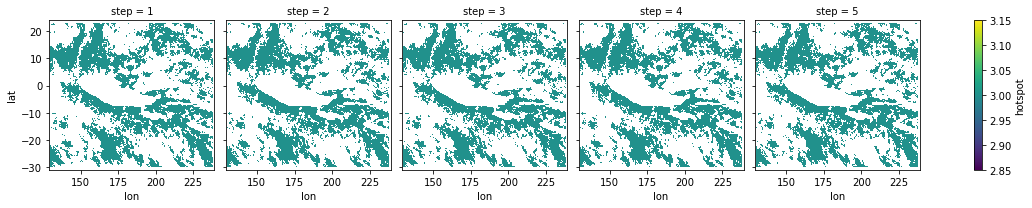

In [86]:
hotspot_3['hotspot'].plot(col='step')

### concatenate along a dummy dimension, calculate the max along this dimension, and optionally selects the domain 

In [87]:
hotspot = xr.concat([hotspot_1, hotspot_2, hotspot_3], dim='category')

In [88]:
hotspot = hotspot.max(dim='category')

In [89]:
domain = [130, 240, -38, 20]

In [90]:
hotspot = hotspot.sel(lat=slice(*domain[2:]), lon=slice(*domain[:2]))

/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


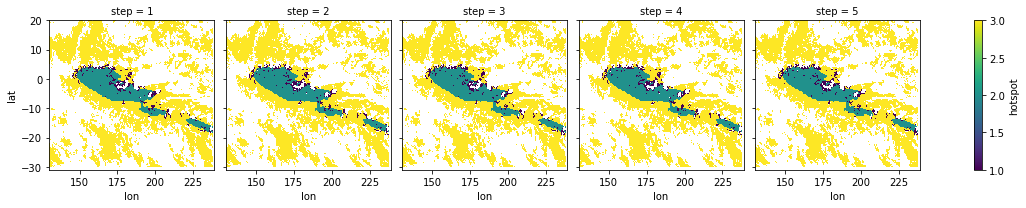

In [91]:
hotspot['hotspot'].plot(col='step')

### adds the mask 

In [92]:
hotspot['mask'] = consolidated_dset['EEZ']

### Now plots 

In [93]:
cbar_kwargs = {}
cbar_kwargs['ticks'] = np.arange(1.5, 4+0.5, 1)
cbar_kwargs['shrink'] = 0.5
cbar_kwargs['orientation'] = 'vertical'
cbar_kwargs['aspect'] = 10

In [94]:
cbar_ticklabels = ['Areas moving in to\nwater stress conditions', 'Current water stress\nconditions persisting',  'Current water stress\nconditions potentially easing']

In [95]:
# rgbs = ['#ffcc00', '#ff0000', '#ccff99']
rgbs = ['#F99D1C', '#F04E37', '#A2D06D']

In [96]:
cmap = matplotlib.colors.ListedColormap(rgbs)

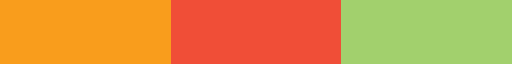

In [97]:
cmap

In [98]:
if period == 'seasonal': 
    plabel = 'season'
elif period == 'monthly': 
    plabel = 'month'

In [99]:
from calendar import month_name

In [100]:
month_name = list(month_name)

In [101]:
month_name += month_name

In [102]:
period

'monthly'

In [103]:
month_name[month + 1]

'October'

/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


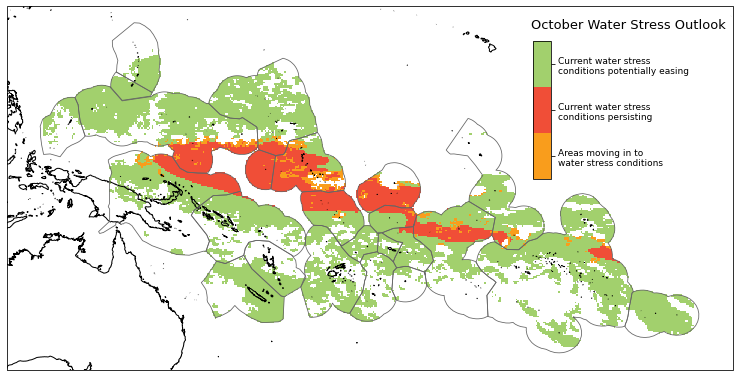

In [104]:
f, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)}, figsize=(13, 8))

im = (hotspot['hotspot'] * hotspot['mask']).sel(step=offset).plot(ax=ax,
                transform=ccrs.PlateCarree(), \
                levels=[1,2,3,4], add_colorbar=False, cmap=cmap)

plot.add_geom(ax, geoms=EEZs)

ax.coastlines(resolution='10m')

cbar_ax = ax.axes.inset_axes([0.725, 0.525, 0.025, 0.38])

cb = plt.colorbar(im, cax=cbar_ax, **cbar_kwargs)

cb.ax.minorticks_off()

cb.ax.set_yticklabels(cbar_ticklabels, fontsize=9)

# plot.make_gridlines(ax, lon_step=20, lat_step=10)

ax.set_title("") 

if period == 'monthly': 
    title = f"{month_name[month + 1]} Water Stress Outlook"
elif period == 'seasonal':
    title = f"{month_name[month + 1]} - {month_name[month + 3]} Water Stress Outlook"

ax.text(0.99, 0.95, title, fontsize=13, fontdict={'color':'k'}, bbox=dict(facecolor='w', edgecolor='w'), horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)

# ax.set_extent(domain)

f.savefig(f'./hotspots_prototype_{month}_{year}_{period}_forecast.png', dpi=200, bbox_inches='tight', facecolor='w')